In [ ]:
import comet_ml as comet
import IPython
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from typing import Dict, List, Any, DefaultDict, Optional
from collections.abc import Callable
import numpy as np
import textwrap
from collections import defaultdict
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
API = comet.API()

### General Setup

**NOTE:** It is expected that the Notebooks are run **inside VS Code** as it allows the pathing for `task_configs` to work. If it is run outside a VS Code instance, please adjust the following line:

```py
notebook_name = "/".join(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
)
```

The cell down below has the following configuration attributes, which might need adjustment depending on changes of the experimental design

- `metrics`: Inside this dictionary the keys represent the actual names of the metric, as they are displayed on `comet`, while the values are simply just given the according type that will be fetched from online.
  
- `parameters`: The parameters describe general experimental setup information, which were passed as arguments upon execution
  
- `task_names`: The task names represent the data sets upon which the Outlier Detection Strategies were trained on
  
- `task_configs`: The task configs represent the path to the configuration files of the `task names`.

In [ ]:
metrics = {
    "AutoFilter_Chen_Like_HTL Count": float,
    "AutoFilter_Chen_Like_avg_duration": float,
    "AutoFilter_Chen_Like_medF1 (No HTL)": float,
    "AutoFilter_Chen_Like_medF1 (With HTL)": float,
    "AutoFilter_Chen_Like_avgF1 (random replacement)": float,
    "AutoFilter_Chen_Like_avgF1 (No HTL)": float,
    "AutoFilter_Chen_Like_avgF1 (With HTL)": float,
    "AutoFilter_Chen_Like_medF1 (random replacement)": float,
    "HDBScanFilter_HTL Count": float,
    "HDBScanFilter_avg_duration": float,
    "HDBScanFilter_medF1 (No HTL)": float,
    "HDBScanFilter_medF1 (With HTL)": float,
    "HDBScanFilter_medF1 (random replacement)": float,
    "HDBScanFilter_avgF1 (No HTL)": float,
    "HDBScanFilter_avgF1 (With HTL)": float,
    "HDBScanFilter_avgF1 (random replacement)": float,
    "IsolationForestFilter_HTL Count": float,
    "IsolationForestFilter_avg_duration": float,
    "IsolationForestFilter_avgF1 (No HTL)": float,
    "IsolationForestFilter_avgF1 (With HTL)": float,
    "IsolationForestFilter_avgF1 (random replacement)": float,
    "IsolationForestFilter_medF1 (No HTL)": float,
    "IsolationForestFilter_medF1 (With HTL)": float,
    "IsolationForestFilter_medF1 (random replacement)": float,
    "LocalOutlierFactorFilter_HTL Count": float,
    "LocalOutlierFactorFilter_avg_duration": float,
    "LocalOutlierFactorFilter_avgF1 (No HTL)": float,
    "LocalOutlierFactorFilter_avgF1 (With HTL)": float,
    "LocalOutlierFactorFilter_avgF1 (random replacement)": float,
    "LocalOutlierFactorFilter_medF1 (No HTL)": float,
    "LocalOutlierFactorFilter_medF1 (With HTL)": float,
    "LocalOutlierFactorFilter_medF1 (random replacement)": float,
    "LoserFilter_Plain_HTL Count": float,
    "LoserFilter_Plain_avg_duration": float,
    "LoserFilter_Plain_avgF1 (No HTL)": float,
    "LoserFilter_Plain_avgF1 (With HTL)": float,
    "LoserFilter_Plain_avgF1 (random replacement)": float,
    "LoserFilter_Plain_medF1 (No HTL)": float,
    "LoserFilter_Plain_medF1 (With HTL)": float,
    "LoserFilter_Plain_medF1 (random replacement)": float,
    "SingleStepEntropy_SimplePseudo_HTL Count": float,
    "SingleStepEntropy_SimplePseudo_avg_duration": float,
    "SingleStepEntropy_SimplePseudo_avgF1 (No HTL)": float,
    "SingleStepEntropy_SimplePseudo_avgF1 (With HTL)": float,
    "SingleStepEntropy_SimplePseudo_avgF1 (random replacement)": float,
    "SingleStepEntropy_SimplePseudo_medF1 (No HTL)": float,
    "SingleStepEntropy_SimplePseudo_medF1 (With HTL)": float,
    "SingleStepEntropy_SimplePseudo_medF1 (random replacement)": float,
}
parameters = {
    "strategy_name": str,
    "filter_strategy_name": str,
    "seed": int,
    "task": str,
}

task_names = [
    "ag-news",
    "dbpedia",
    "fnc1",
    "imdb",
    "qnli",
    "rotten-tomatoes",
    "sst2",
    "trec",
    "wiki-talk",
]

version = "x"
task_names = [version + t for t in task_names]

# This gets the location of the Notebook, needs VSCode to be executed correctly
notebook_name = "/".join(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
)

BASE_PATH = Path(notebook_name).parent
CONFIGS_PATH = BASE_PATH.parent / "Configs" / "Tasks"

task_configs = {
    "xAG News": CONFIGS_PATH / "ag_news.json",
    "xDBPedia": CONFIGS_PATH / "dbpedia.json",
    "xFNC1": CONFIGS_PATH / "fnc_one.json",
    "xIMDB": CONFIGS_PATH / "imdb.json",
    "xQNLI": CONFIGS_PATH / "qnli.json",
    "xRotten Tomatoes": CONFIGS_PATH / "rotten_tomatoes.json",
    "xSST2": CONFIGS_PATH / "sst2.json",
    "xTREC": CONFIGS_PATH / "trec.json",
    "xWiki Talk": CONFIGS_PATH / "wiki_talk.json",
}

seed_count = 20  # How many different seeds do we expect?

COMET_WORKSPACE = "sklearn-20"
filter_names = [
    "HDBScanFilter LocalOutlierFactorFilter IsolationForestFilter SimpleDSM SemanticAE SimpleSS"
]

In [ ]:
def extract_used_metrics(experiment_metrics: List[Dict[str, Any]]) -> List[Dict]:
    """
    Extract a list of unique metrics from the given experiment metrics that are also present in the `metrics` list.

    Args:
        experiment_metrics (List[Dict[str, Any]]): A list of dictionaries where each dictionary
            represents a metric with various attributes, including "metricName".

    Returns:
        List[Dict]: A list of unique metric dictionaries where "metricName" exists in the global `metrics` list.
    """
    metrics_used: List[Dict] = []
    for metric in experiment_metrics:
        if metric["metricName"] in metrics:
            metrics_used.append(metric)
    return metrics_used


def extract_paremeter_value(
    parameters_used: List[Dict[str, Any]], parameter_name: str
) -> str | float:
    """
    Extracts the current value of a specified parameter from a list of parameters.

    Args:
        parameters_used (List[Dict[str, Any]]): A list of dictionaries containing parameter information.
        parameter_name (str): The name of the parameter to extract.

    Returns:
        str | float: The current value of the specified parameter.
    """
    parameters_dict = [
        entry for entry in parameters_used if entry.get("name") == parameter_name
    ]
    return parameters_dict[0]["valueCurrent"]


def load_experiment_data(
    experiment: comet.APIExperiment,
) -> DefaultDict[str, DefaultDict[str, DefaultDict[str, Dict[str, Any]]]]:
    """
    Loads and organizes experiment data, including metrics, parameters, and assets.

    Args:
        experiment (comet.APIExperiment): A Comet APIExperiment object containing experiment data.

    Returns:
        DefaultDict[str, DefaultDict[str, DefaultDict[str, Dict[str, Any]]]]: A nested dictionary with tasks, seeds, and experiment data.
    """

    experiment_parameters = experiment.get_parameters_summary()
    task = extract_paremeter_value(experiment_parameters, "task")
    seed = extract_paremeter_value(experiment_parameters, "seed")

    download_assets(experiment, task, seed)



def download_assets(experiment:comet.APIExperiment, task: str, seed: str) -> Dict[str, np.ndarray]:
    """
    Downloads and saves the assets of an experiment, filtering out unnecessary files.

    Args:
        experiment (comet.APIExperiment): A Comet APIExperiment object containing the experiment data.
        task (str): The task name associated with the experiment.
        seed (str): The seed value associated with the experiment.
        project_name (str): The name of the project associated with the experiment.

    Returns:
        Dict[str, np.ndarray]: A dictionary of downloaded assets, loaded as NumPy arrays.
    """
    assets = experiment.get_asset_list()
    filtered_assets = [
        asset
        for asset in assets
        if "durations" not in asset["fileName"]
        and not asset["fileName"].endswith(".py")
    ]

    asset_ids = []
    for asset in filtered_assets:
        asset_ids.append((asset["fileName"], asset["assetId"]))

    for file_name, idx in asset_ids:
        asset_data = experiment.get_asset(idx)
        asset_path = Path(f"./cache/assets/{COMET_WORKSPACE}/{task}/{seed}/{file_name}")
        asset_path.parent.mkdir(parents=True, exist_ok=True)
        with open(asset_path, "wb") as f:
            f.write(asset_data)


def download_workspace_data(task_name: str) -> None:
    """
    Loads experiment data for a specific project from the Comet workspace.

    Args:
        project_name (str): The name of the project to load data from.
    """
    experiments = API.get(workspace=COMET_WORKSPACE, project_name=task_name)
    for exp in experiments:
        load_experiment_data(exp)


def main() -> None:
    for task_name in task_names:
        download_workspace_data(task_name)

# main()

In [24]:
def is_integer_directory(dir_path: Path) -> bool:
    """Check if the directory name is an integer."""
    return dir_path.name.isdigit()

def collect_asset_paths(ASSET_PATHS: Optional[Path] = Path("cache", "assets", COMET_WORKSPACE)) -> DefaultDict[str, List]:
    TASK_ASSET_MAP = defaultdict(list)
    for dir_path in ASSET_PATHS.glob('**/*'):
        if dir_path.is_dir() and is_integer_directory(dir_path):
            task_name = dir_path.parent.name
            if task_name != COMET_WORKSPACE:
                TASK_ASSET_MAP[task_name].append(dir_path)

    return TASK_ASSET_MAP

def find_missing_seeds_count(task_asset_map):
    seed_map = defaultdict(list)
    for task, asset_paths in task_asset_map.items():
        seeds = [int(path.name) for path in asset_paths]
        missing_seeds: List | None = np.setdiff1d(np.arange(42, 42 + seed_count), seeds).tolist()
        seed_map[task] = missing_seeds


    return seed_map


TASK_ASSET_MAP = collect_asset_paths()
missing_seeds = find_missing_seeds_count(task_asset_map=TASK_ASSET_MAP)
missing_seeds

defaultdict(list,
            {'xFNC1': [],
             'xAG News': [],
             'xSST2': [],
             'xTREC': [42, 57, 58, 60, 61],
             'xWiki Talk': [],
             'xDBPedia': [48, 59, 60],
             'xRotten Tomatoes': [],
             'xIMDB': [45, 46, 47, 49],
             'xQNLI': [44]})

### (Optional) Find Missing Experimental Seeds

This cell's purpose is to collect all the experimental runs that were designated towards a chosen `workspace` and ended up failing, i.e. due to sudden HPC issues that occured during execution in a CSV file called `missing_std_experiments.csv`. The following code sample from cells above shows where the `workspace` name gets assigned. Change it accordingly for your analysis.

```py
def load_workspace_data(project_name: str) -> List[DefaultDict[str, DefaultDict[str, DefaultDict[str, pd.DataFrame]]]]:
    experiments = API.get(workspace=COMET_WORKSPACE, project_name=project_name)
    ...
```

#### Structure of `missing_std_experiments.csv`

In the following example the general structure of the generated file is displayed:
| seed| filter | task |
| --- | --- | --- |
| 42 | HDBScanFilter LocalOutlierFactorFilter IsolationForestFilter SimpleDSM SemanticAE SimpleSS | rotten_tomatoes|

- `seed`: Represents the seed that was used
- `filter`: Is the name of the filter strategies that were used
- `task`: The name of the workspace where it was found

In [25]:
collected_data: List[pd.DataFrame] = []

def get_task_config(task: Path) -> Path:
    """Transform in the input `task` into a Path object.

    Args:
        task (Path): A Path object, containing the full Path to the config

    Returns:
        Path: A relative Path based on the `task_configs` dict based on the relative Path: `Configs/Task/`
    """
    return task.relative_to(task.parents[2])


for task_name, missed_seeds in missing_seeds.items():
    task = get_task_config(task_configs[task_name])
    if missed_seeds:
        df = pd.DataFrame(
        [
            {"seed": seed, "filter": filter_names[0], "task": task, "workspace": COMET_WORKSPACE}
            for seed in missed_seeds
        ]
        )
        collected_data.append(df)

if collected_data:
    missing_experiments = pd.concat(collected_data)
    missing_experiments = missing_experiments[
        missing_experiments["filter"].isin(filter_names)
    ]
    missing_experiments.to_csv("missing_std_experiments.csv", mode="a")
    missing_experiments

In [26]:
def find_intervals(seeds: list[int]) -> List[List[int]]:
    """Finds the largest contiguous intervals in a list of integers. It groups consecutive integers into a sublist.

    Args:
        seeds (list[int]): A list of integers to find (all and) the largest intervals from.

    Raises:
        ValueError: If the provided list for `seeds` is empty.

    Returns:
        List[List[int]]: A list of lists, where each inner list contains a contiguous interval of integers.

    Examples:
        >>> find_intervals([1, 2, 3, 5, 6, 7, 9])
        [[1, 2, 3], [5, 6, 7], [9]]

        >>> find_intervals([10, 11, 13, 14, 15, 16])
        [[10, 11], [13, 14, 15, 16]]
    """
    if not seeds:
        raise ValueError(
            f"The provided list for `seeds` ({seeds}) has: {len(seeds)} elements!"
        )
    intervals = []

    sub_interval = [seeds[0]]

    for index in range(1, len(seeds)):
        if seeds[index] == seeds[index - 1] + 1:
            sub_interval.append(seeds[index])
        else:
            # Add the completed interval to the result and start a new interval right after
            intervals.append(sub_interval)
            sub_interval = [seeds[index]]

    # Append the last interval, as it only gets added within the iteration, so the last one would be missing
    intervals.append(sub_interval)
    return intervals


def generate_task_scripts(
    intervals: List[List[int]], task_config: str, workspace: str
) -> None:
    for index, interval in enumerate(intervals):
        start = interval[0] - 42
        end = interval[-1] - 42

        # A task has the structure "Configs/Tasks/<task_name>.json" -> we want the <task_name>.json, then remove the ".json"
        task_name_cleaned = task_config.split("/")[-1].split(".")[0]
        # Common SLURM script header
        slurm_header = textwrap.dedent(
            f"""\
            #!/bin/bash
            #SBATCH --nodes=1              # request 1 node
            #SBATCH --cpus-per-task=6      # use 6 threads per task
            #SBATCH --gres=gpu:1           # use 1 GPU per node (i.e. use one GPU per task)
            #SBATCH --time=100:00:00       # run for 100 hours
            #SBATCH --mem=10G
            #SBATCH --account=p_ml_il
            #SBATCH --job-name={workspace}-{task_config}
            #SBATCH --output=./slurm-runs/{workspace}/{task_name_cleaned}-%a-%A-%j.out
            #SBATCH --exclude=i8008,i8009,i8011,i8014,i8021,i8023
        """
        )

        # Array setup if start and end differ
        array_directive = f"#SBATCH --array={start}-{end}\n" if start != end else ""

        # Command to calculate random seed
        seed_command = (
            f"random_seed=$((42 + ${{SLURM_ARRAY_TASK_ID}}))"
            if start != end
            else f"random_seed={interval[0]}"
        )

        # Common SLURM script body
        slurm_body = textwrap.dedent(
            f"""\
            {array_directive}
            module --force purge
            module load release/23.04 GCC/11.3.0 Python/3.10.4
            source /data/horse/ws/toma076c-outlier-detection/venv/bin/activate

            nvidia-smi
            hostname

            # Calculate the random seed within the SLURM script
            {seed_command}

            echo "Seed: ${{random_seed}}"

            srun python3 main.py \
                --task_config ./{task_config} \
                --experiment_config ./Configs/standard.json \
                --filter_strategy_name HDBScanFilter LocalOutlierFactorFilter IsolationForestFilter SimpleDSM SemanticAE SimpleSS \
                --comet_api_key {API.api_key} \
                --comet_workspace {workspace} \
                --random_seed ${{random_seed}}
        """
        )

        # Write the complete SLURM script
        with open(f"{workspace}-{task_name_cleaned}-{index}.sh", "w+") as rsh:
            rsh.write(slurm_header + slurm_body)


def collect_missing_experiment_seeds(missing_experiments: pd.DataFrame) -> None:
    unique_tasks = missing_experiments["task"].unique()
    for task in unique_tasks:
        # We only care for all the rows that match the current task, so we create a subset of the df
        task_df = missing_experiments.loc[missing_experiments["task"] == task]
        seeds = sorted(
            task_df["seed"].values
        )  # Sort the seeds, to assure the biggest intervals are found
        workspace = task_df["workspace"].iloc[0]
        task_intervals = find_intervals(seeds)
        generate_task_scripts(intervals=task_intervals, task_config=task, workspace=workspace)


# missing_experiments = pd.read_csv("missing_std_experiments.csv")
# x = collect_missing_experiment_seeds(missing_experiments=missing_experiments)

### Plot Filter vs No Filter & Filter vs Random

cache/assets/sklearn-20/xFNC1/61/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/59/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/50/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/57/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/56/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/51/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/58/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/58/AutoFilter_Chen_Like_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/60/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/42/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/45/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/44/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/43/LoserFilter_Plai

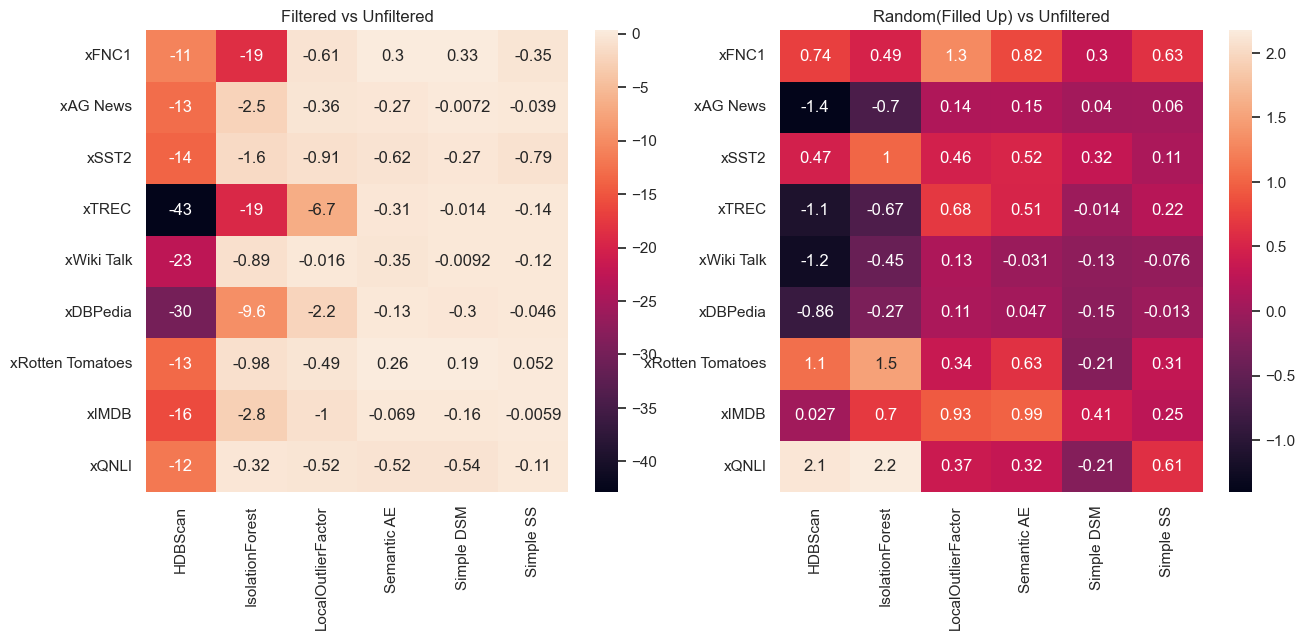

In [27]:
filter_names_clean = {
    "LoserFilter_Plain": "Simple DSM",
    "AutoFilter_Chen_Like": "Semantic AE",
    "SingleStepEntropy_SimplePseudo": "Simple SS",
    "HDBScanFilter": "HDBScan",
    "IsolationForestFilter": "IsolationForest",
    "LocalOutlierFactorFilter": "LocalOutlierFactor",
}

def load_asset_data(workspace_data: DefaultDict[str, List[Path]]) -> Dict[str, pd.DataFrame]:

    asset_data = {}
    for task_name, asset_dirs in workspace_data.items():
        collected_assets = []
        for asset_dir in asset_dirs:
            asset_paths = asset_dir.glob("*")
            collected_dfs = []
            for asset_path in asset_paths:
                data = np.load(asset_path)
                if data.size == 0:
                    print(f"{asset_path} is empty")
                df = pd.DataFrame(data={asset_path.name[:-4]: [data]})
                if df.empty:
                    print(f"Careful! For '{task_name}', the '{asset_path}' file is empty.")
                else:
                    collected_dfs.append(df)

            collected_assets.append(pd.concat(collected_dfs, axis=1))

        asset_data[task_name] = pd.concat(collected_assets, axis=0, ignore_index=True)


    return asset_data


def clean_up_asset_name(asset_name: str) -> str:
    """
    This function removes the `_no_htl` and `_random` extension from the asset.
    For example: `AutoFilter_Chen_Like_no_htl` would be transformed into `AutoFilter_Chen_Like`.
    Args:
        asset_name (str): The name of the asset to be (potentially) changed, as some do not have the aforementioned suffixes

    Returns:
        str: The updated asset_name
    """
    if asset_name.endswith("_no_htl") or asset_name.endswith("_random"):
        asset_name = asset_name[:-7]

    cleaned_asset = filter_names_clean[asset_name]
    return cleaned_asset


def calculate_averages(
    asset_data: Dict[str, Dict[str, pd.DataFrame]]
) -> DefaultDict[str, DefaultDict[str, np.float64]]:

    summarised_data = defaultdict(lambda: defaultdict(dict))

    for task_name, asset_df in asset_data.items():
        for asset_name in asset_df.columns:
            arrays_for_col = asset_df[asset_name].values
            flattened_array = np.concatenate(arrays_for_col)
            if flattened_array.size == 0:
                print(f"Empty array found for: {asset_name} in {task_name}")
            else:
                mean = flattened_array.mean()
                summarised_data[task_name][asset_name] = mean

    return summarised_data


def prepare_data():
    workspace_data = collect_asset_paths()
    asset_data = load_asset_data(workspace_data=workspace_data)
    summarised_data = calculate_averages(asset_data)
    return summarised_data

def transform_into_percentual_difference(asset_df: pd.DataFrame) -> pd.DataFrame:
    for col in asset_df.columns:
        if col != "HTL":
            asset_df[col] = (asset_df[col] - asset_df["HTL"]).mul(100)

    return asset_df


def filter_no_htl(asset_name: str) -> bool:
    """
    This is a helper function for the `create_comparison_df()` function. It is used to compare `No HTL` with `HTL`, so the filter condition looks for assets that contain `_no_htl` in their name.

    Args:
        asset_name (str): The asset to check for.

    Returns:
        bool: Returns `True` if the asset ends with `_no_htl`, else defaults to `False`.
    """
    return asset_name.endswith("_no_htl")


def filter_random(asset_name: str) -> bool:
    """
    This is a helper function for the `create_comparison_df()` function. It is used to compare `Random (Filled Up)` with `HTL`, so the filter condition looks for assets that contain `_random` in their name.

    Args:
        asset_name (str): The asset to check for.

    Returns:
        bool: Returns `True` if the asset ends with `_random`, else defaults to `False`.
    """
    return asset_name.endswith("_random")


def create_comparison_df(
    data: DefaultDict[str, DefaultDict[str, np.float64]],
    filter_condition: Callable[[str], bool],
) -> pd.DataFrame:
    """
    Generates a comparison DataFrame by filtering asset names based on a given condition
    and transforming them into percentual differences.

    This function processes a nested dictionary structure where each task contains a dictionary
    of assets and their corresponding values. For each task, it filters the asset names according
    to the provided `filter_condition` function, cleans up asset names as needed, and collects
    assets ending with "HTL". The resulting DataFrame for each task is transformed into percentual
    differences and concatenated into a final DataFrame.

    Args:
        data (DefaultDict[str, DefaultDict[str, np.float64]]):
            A nested dictionary where the outer key is the task name, the inner dictionary contains
            asset names as keys and their values as floats.

        filter_condition (Callable[[str], bool]):
            A function that takes an asset name (string) and returns a boolean indicating whether
            the asset should be included in the comparison. The function is responsible for determining
            if an asset meets the filtering criteria.

    Returns:
        pd.DataFrame:
            A concatenated DataFrame containing percentual differences for the filtered assets
            across all tasks.
    """

    dfs: list[pd.DataFrame] = []
    for task_name, asset_dict in data.items():
        collected_assets = {}
        for asset_name, asset_value in asset_dict.items():
            if filter_condition(asset_name):
                cleaned_asset = clean_up_asset_name(asset_name)
                collected_assets[cleaned_asset] = asset_value
            elif asset_name.endswith("HTL"):
                collected_assets[asset_name] = asset_value

        asset_df = transform_into_percentual_difference(
            asset_df=pd.DataFrame(data=collected_assets, index=[task_name])
        )
        dfs.append(asset_df)

    merged_df = pd.concat(dfs)
    return merged_df


def main():
    summarised_data = prepare_data()
    data_filtered = create_comparison_df(summarised_data, filter_no_htl)
    data_unfiltered = create_comparison_df(summarised_data, filter_random)

    sns.set_theme()
    sns.xkcd_palette
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.heatmap(
        data=data_filtered[data_filtered.columns.difference(["HTL"])],
        annot=True,
        ax=axes[0],
    )
    axes[0].set_title("Filtered vs Unfiltered")
    sns.heatmap(
        data=data_unfiltered[data_unfiltered.columns.difference(["HTL"])],
        annot=True,
        ax=axes[1],
    )
    axes[1].set_title("Random(Filled Up) vs Unfiltered")

main()



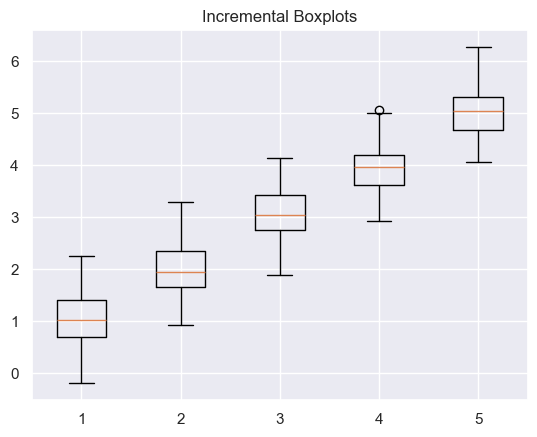

In [28]:
# ChatGPT Example for Above, can remove this cell

import matplotlib.pyplot as plt
import numpy as np

# Initialize the figure and axes for the boxplots
fig, ax = plt.subplots()
ax.set_title("Incremental Boxplots")

# This list will hold different datasets for individual boxplots
datasets = []

# Assuming you have a mechanism to add datasets one at a time
for i in range(1, 6):  # Example loop to simulate adding 5 datasets incrementally
    # Simulate generating or loading a new dataset
    new_data = np.random.normal(loc=i, scale=0.5, size=100)
    datasets.append(new_data)  # Add the new dataset to the list

# Clear the axes for fresh plot (optional if you want to redraw the boxplots)
ax.clear()
# Plot all the current datasets as individual boxplots
ax.boxplot(datasets)
ax.set_title("Incremental Boxplots")
plt.draw()  # Redraw the plot with the new data
plt.pause(0.5)  # Pause to visually confirm the addition, adjust or remove as needed

plt.show()

### Significance Test

In [29]:
# 5.3 Significance Test from Paper

# HTL mit NO HTL Vergleich & Random mit NO HTL vergleichen <-- Random hinzufügen (einfach assets laden)
import deepsig
import pandas as pd


def helper_function(significance_test_data: Dict[str, pd.DataFrame], filter_condition: Callable[[str], bool]) -> Dict[str, Dict[str, np.ndarray]]:
    results = {}
    for task_name, asset_df in significance_test_data.items():
        collected_assets = {}
        for col in asset_df.columns:
            if filter_condition(col):
                cleaned_asset = clean_up_asset_name(col)
                flattened_array = np.concatenate(asset_df[col].values)
                if flattened_array.size == 0:
                    print(f"Empty array found for: {col} in {task_name}")
                else:
                    collected_assets[cleaned_asset] = flattened_array
            elif col.endswith("HTL"):
                collected_assets[col] = np.concatenate(asset_df[col].values)

        results[task_name] = collected_assets

    return results


def prepare_significance_test_data(filter_condition: Callable[[str], bool]) -> Dict[str, pd.DataFrame]:
    workspace_data = collect_asset_paths()
    asset_data = load_asset_data(workspace_data=workspace_data)

    return helper_function(asset_data, filter_condition)


no_htl_vs_htl = prepare_significance_test_data(filter_no_htl)

results = []
for task_name, assets_dict in no_htl_vs_htl.items():
    aso_test = {}
    task_aso = []
    htl_data = assets_dict["HTL"]
    for filter_strategy, no_htl_filter_data in assets_dict.items():
        if filter_strategy != "HTL":
            if (len(no_htl_filter_data) != seed_count * 30) or (len(htl_data) != seed_count * 30):
                print(f"Error! In {task_name} the filterstrategy '{filter_strategy}' has '{len(no_htl_filter_data)}' no HTL Data, and '{len(htl_data)}' HTL Data but expected were: '{seed_count * 30}'")


            # better = deepsig.aso(no_htl_filter_data, htl_data, num_jobs=8, seed=42)
            # task_aso.append(better)

#     assets_dict.pop("HTL", None)
#     results.append(pd.DataFrame(data=[task_aso], columns=assets_dict.keys(), index=[f"{task_name}_htl_better"]))

# df = pd.concat(results)
# df.to_csv("test.csv")


cache/assets/sklearn-20/xFNC1/61/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/59/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/50/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/57/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/56/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/51/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/58/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/58/AutoFilter_Chen_Like_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/60/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/42/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/45/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/44/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/43/LoserFilter_Plai

### Marked Samples Measurements

cache/assets/sklearn-20/xFNC1/61/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/59/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/50/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/57/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/56/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/51/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/58/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/58/AutoFilter_Chen_Like_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/60/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/42/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/45/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/44/LoserFilter_Plain_Marked_Samples.npy is empty
cache/assets/sklearn-20/xFNC1/43/LoserFilter_Plai

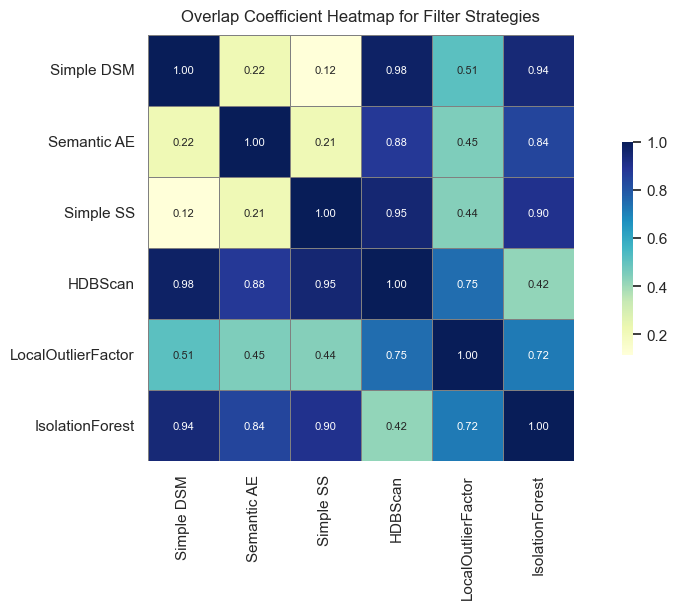

In [42]:
from itertools import combinations

def collect_asset_paths(ASSET_PATHS: Optional[Path] = Path("cache", "assets", COMET_WORKSPACE)) -> DefaultDict[str, List]:
    TASK_ASSET_MAP = defaultdict(list)
    for path in ASSET_PATHS.glob('**/*'):
        if path.name.endswith("_Marked_Samples.npy"):
            task_name = path.parent.parent.name
            if task_name != COMET_WORKSPACE:
                TASK_ASSET_MAP[task_name].append(path)

    return TASK_ASSET_MAP

def load_asset_data_jaccard(workspace_data: DefaultDict[str, List[Path]]) -> pd.DataFrame:

    collected_dfs = defaultdict(list)
    for task_name, assets in workspace_data.items():
        for asset_path in assets:
            data = np.load(asset_path)
            if data.size == 0:
                print(f"{asset_path} is empty")

            filter_strategy_name = filter_names_clean[asset_path.name.replace("_Marked_Samples.npy", "")]
            collected_dfs[filter_strategy_name].append(data)

    asset_data = pd.DataFrame(collected_dfs)
    return asset_data

def load_asset_data(workspace_data: DefaultDict[str, List[Path]]) -> Dict[str, pd.DataFrame]:
    results = {}
    for task_name, assets in workspace_data.items():
        collected_dfs = defaultdict(list)
        for asset_path in assets:
            data = np.load(asset_path)
            if data.size == 0:
                print(f"{asset_path} is empty")

            filter_strategy_name = filter_names_clean[asset_path.name.replace("_Marked_Samples.npy", "")]
            collected_dfs[filter_strategy_name].append(data)

        results[task_name] = pd.DataFrame(collected_dfs)
    return results


def prepare_data():
    workspace_data = collect_asset_paths()
    asset_data = load_asset_data(workspace_data=workspace_data)
    return asset_data

def prepare_data_jaccard():
    workspace_data = collect_asset_paths()
    asset_data = load_asset_data_jaccard(workspace_data=workspace_data)
    return asset_data

def average_marked_samples() -> None:
    marked_samples = prepare_data()

    dfs = []
    for task_name, df in marked_samples.items():
        collected_assets = {}
        for col in df.columns:
            avg_marked = np.concatenate(df[col].values).size / df[col].size
            collected_assets[col] = avg_marked

        asset_df = pd.DataFrame(data=collected_assets, index=[task_name])
        dfs.append(asset_df)

    merged_df = pd.concat(dfs)

    sns.set_theme()
    colors = sns.color_palette("YlGnBu", as_cmap=True)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    sns.heatmap(
        data=merged_df,
        cmap=colors,                   # Use stairwell style color map
        annot=True,                    # Annotate cells with values
        fmt=".2f",                     # Format annotations to 2 decimal places
        annot_kws={"size": 8},         # Font size for annotations
        linewidths=0.5,                # Thin borders for each cell
        linecolor='grey',              # Grey borders to define the stairwell look
        cbar_kws={'shrink': 0.5},      # Shrink color bar for fitting
    )

    # Adjust the layout to make boxes fit better
    plt.tight_layout()
    ax.set_title(f"Average Marked Samples for each Filter Strategy over {seed_count} seeds.", fontsize=12, pad=10)  # You can change the title, font size, and padding

    plt.show()

def calculate_jaccard(x1, x2):
    intersection = np.intersect1d(x1, x2).size
    union = np.union1d(x1, x2).size
    return intersection / union


def calculate_overlap(x1, x2):
    intersection = np.intersect1d(x1, x2).size
    min_set = min(x1.size, x2.size)
    return intersection / min_set

def jaccard_coefficient() -> None:
    marked_samples = prepare_data_jaccard()

    strategies = marked_samples.columns
    jaccard_matrix = pd.DataFrame(index=strategies, columns=strategies)
    for strategy1, strategy2 in combinations(marked_samples.columns, 2):
        jaccard_index = calculate_jaccard(
            np.concatenate(marked_samples[strategy1].values),
            np.concatenate(marked_samples[strategy2].values)
        )
        jaccard_matrix.loc[strategy1, strategy2] = jaccard_index
        jaccard_matrix.loc[strategy2, strategy1] = jaccard_index
    
    np.fill_diagonal(jaccard_matrix.values, 1)
    
    jaccard_matrix = jaccard_matrix.astype(float)

    # Set up the plot in stairwell style
    sns.set_theme(style="white")
    colors = sns.color_palette("YlGnBu", as_cmap=True)  # Stairwell-style color palette

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.heatmap(
        data=jaccard_matrix,           # Jaccard matrix as data
        cmap=colors,                   # Use stairwell style color map
        annot=True,                    # Annotate cells with values
        fmt=".2f",                     # Format annotations to 2 decimal places
        annot_kws={"size": 8},         # Font size for annotations
        linewidths=0.5,                # Thin borders for each cell
        linecolor='grey',              # Grey borders to define the stairwell look
        cbar_kws={'shrink': 0.5},      # Shrink color bar for fitting
        square=True                    # Square cells for a structured look
    )

    plt.tight_layout()
    ax.set_title("Jaccard Coefficient Heatmap for Filter Strategies", fontsize=12, pad=10)
    plt.show()

def overlap_coefficient() -> None:
    marked_samples = prepare_data_jaccard()

    strategies = marked_samples.columns
    overlap_matrix = pd.DataFrame(index=strategies, columns=strategies)
    for strategy1, strategy2 in combinations(marked_samples.columns, 2):
        overlap_index = calculate_overlap(
            np.concatenate(marked_samples[strategy1].values),
            np.concatenate(marked_samples[strategy2].values)
        )
        overlap_matrix.loc[strategy1, strategy2] = overlap_index
        overlap_matrix.loc[strategy2, strategy1] = overlap_index
    
    np.fill_diagonal(overlap_matrix.values, 1)
    
    overlap_matrix = overlap_matrix.astype(float)

    # Set up the plot in stairwell style
    sns.set_theme(style="white")
    colors = sns.color_palette("YlGnBu", as_cmap=True)  # Stairwell-style color palette

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.heatmap(
        data=overlap_matrix,           # Overlap matrix as data
        cmap=colors,                   # Use stairwell style color map
        annot=True,                    # Annotate cells with values
        fmt=".2f",                     # Format annotations to 2 decimal places
        annot_kws={"size": 8},         # Font size for annotations
        linewidths=0.5,                # Thin borders for each cell
        linecolor='grey',              # Grey borders to define the stairwell look
        cbar_kws={'shrink': 0.5},      # Shrink color bar for fitting
        square=True                    # Square cells for a structured look
    )

    plt.tight_layout()
    ax.set_title("Overlap Coefficient Heatmap for Filter Strategies", fontsize=12, pad=10)
    plt.show()


# average_marked_samples()

# jaccard_coefficient()

overlap_coefficient()

### Marked Samples Measurements